In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import DotDict
import yaml

# Load the map definition from file
filepath = '../../../moro_simulator' + '/world/maze_map.yaml'
with open(filepath) as f:
    msg = DotDict(yaml.safe_load(f))

<IPython.core.display.Javascript object>


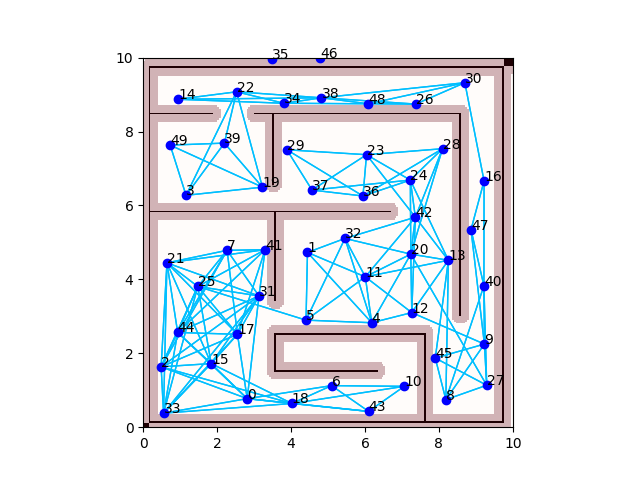

In [3]:
%matplotlib notebook

from probabilistic_roadmap import ProbabilisticRoadmap
import matplotlib.pyplot as plt

import numpy as np

# Set random seed to compare different parameters
np.random.seed(45)

prm = ProbabilisticRoadmap(msg)
prm.plot()

for node, coord in enumerate(prm.nodes):
    plt.text(coord[0], coord[1], str(node))

plt.show()

In [4]:
from moro_navigation.shortest_path import dynamic_programming

In [5]:
path = dynamic_programming(prm.graph, 10, 3)
path

deque([10, 18, 15, 25, 5, 4, 12, 9, 40, 16, 30, 38, 22, 3])

<IPython.core.display.Javascript object>


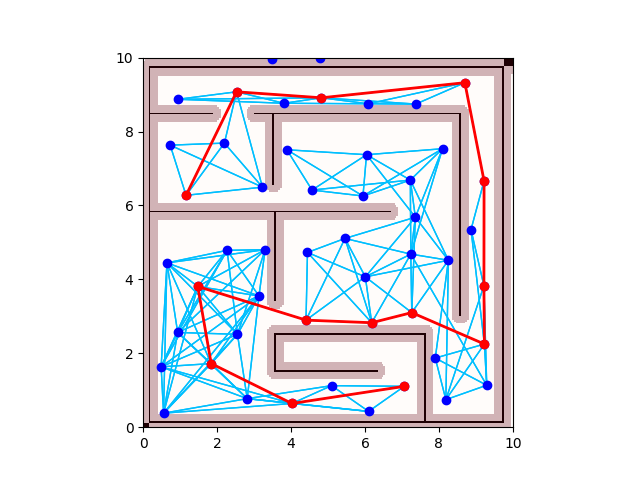

In [6]:
plt.figure()
prm.plot(path)
plt.show()